### About Project:
1) This is Project of time series forecasting, not time series analysis. The primary concern of this Project is using historical data to predict the future, not to understand the past.

2) This Project is not a treatment of complex time series problems. It does not deals with advanced topics like multi-step sequence forecasts, multivariate time series problems or spatial-temporal prediction problems.


Time series forecasting can be framed as a supervised learning problem. 
Let make clear of the terms : 

 Classiﬁcation: A classiﬁcation problem is when the output variable is a category, such as red and blue or disease and no disease.

 Regression: A regression problem is when the output variable is a real value, such as dollars or weight. The contrived example above is a regression problem.

 Univariate Time Series: These are datasets where only a single variable is observed at each time, such as temperature each hour. The example in the previous section is a univariate time series dataset.

 Multivariate Time Series: These are datasets where two or more variables are observed at each time.

 One-Step Forecast: This is where the next time step (t+1) is predicted.

 Multi-Step Forecast: This is where two or more future time steps are to be predicted.



#### Time Series Analysis
When using classical statistics, the primary concern is the analysis of time series. Time series analysis involves developing models that best capture or describe an observed time series in order to understand the underlying causes. This ﬁeld of study seeks the why behind a time series dataset. This often involves making assumptions about the form of the data and decomposing the time series into constitution components. The quality of a descriptive model is determined by how well it describes all available data and the interpretation it provides to better inform the problem domain.
#### Time Series Forecasting
Making predictions about the future is called extrapolation in the classical statistical handling of time series data. More modern ﬁelds focus on the topic and refer to it as time series forecasting. Forecasting involves taking models ﬁt on historical data and using them to predict future observations. Descriptive models can borrow from the future (i.e. to smooth or remove noise), they only seek to best describe the data. An important distinction in forecasting is that the future is completely unavailable and must only be estimated from what has already happened. The skill of a time series forecasting model is determined by its performance at predicting the future. This is often at the expense of being able to explain why a speciﬁc prediction was made, conﬁdence intervals and even better understanding the underlying causes behind the problem.

#### Steps of this project that we will walk through: Template of this project:
1) Problem Description
2) Test Harness
3) Persitence
4) Data Analysis
5) ARIMA Models
6) Model VAlidation

In [1]:
# Import the necessary library
# Import the necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats.mstats import normaltest

from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline

Following will be used for the reading csv file, here;

 header=0: We must specify the header information at row 0.

 parse dates=True: We give the function a hint that data in the ﬁrst column contains dates that need to be parsed.

 index col=0: We hint that the ﬁrst column contains the index information for the time series.

 squeeze=True: We hint that we only have one data column and that we are interested in a Series and not a DataFrame.


In [3]:
# load the dataset
series=pd.read_csv('Boston_robberies.csv',header=0,index_col=0,parse_dates=True,squeeze=True)
series.head()

Month
1966-01-01    41
1966-02-01    39
1966-03-01    50
1966-04-01    40
1966-05-01    43
Name: Robberies, dtype: int64

##### Problem Description:
The problem is to predict the number of monthly armed robberies in Boston, USA from Jan 1966 to Oct 1975. Total 118 observation .Data can be downloaded from DataMarket (https://goo.gl/KxME8)
##### Test Harness: 
To investigate the data and evaluate candidate models we process it into
1) Defining a Validation Dataset:
The dateset is not current. This means that we cannot easily collect upadtae data to validat the model. Therefore we will pretend that it is Oct 1974 and withhold tha last one year data from anlaysis and model selection . This final year of data will be used to validate the final modle.

2) Developing a method for Model Evaluation: Model Evaluation involves two element.
i) Performance Measure 
ii) Test strategy


In [5]:
len(series)

118

In [6]:
series.size

118

In [7]:
series.info()  # infromation
# since it is series it will give error

AttributeError: 'Series' object has no attribute 'info'

In [8]:
series.describe()    # gives the descriptive statistics

count    118.000000
mean     196.288136
std      128.043602
min       29.000000
25%       85.500000
50%      166.000000
75%      296.750000
max      500.000000
Name: Robberies, dtype: float64

In [28]:

# split the dataset 
split_point=len(series)-12       # 10% to validation
dataset,validation=series[0:split_point],series[split_point:]
# convert these to the csv file
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

In [29]:
series[split_point]

452

In [31]:
# Let see the dataset.csv file
read=pd.read_csv('dataset.csv',header=None, index_col=0,parse_dates=True,squeeze=True)
X=read.values
X

array([ 41,  39,  50,  40,  43,  38,  44,  35,  39,  35,  29,  49,  50,
        59,  63,  32,  39,  47,  53,  60,  57,  52,  70,  90,  74,  62,
        55,  84,  94,  70, 108, 139, 120,  97, 126, 149, 158, 124, 140,
       109, 114,  77, 120, 133, 110,  92,  97,  78,  99, 107, 112,  90,
        98, 125, 155, 190, 236, 189, 174, 178, 136, 161, 171, 149, 184,
       155, 276, 224, 213, 279, 268, 287, 238, 213, 257, 293, 212, 246,
       353, 339, 308, 247, 257, 322, 298, 273, 312, 249, 286, 279, 309,
       401, 309, 328, 353, 354, 327, 324, 285, 243, 241, 287, 355, 460,
       364, 487], dtype=int64)

In [32]:
X=X.astype('float32') # convet to float for easy read and operation
X

array([ 41.,  39.,  50.,  40.,  43.,  38.,  44.,  35.,  39.,  35.,  29.,
        49.,  50.,  59.,  63.,  32.,  39.,  47.,  53.,  60.,  57.,  52.,
        70.,  90.,  74.,  62.,  55.,  84.,  94.,  70., 108., 139., 120.,
        97., 126., 149., 158., 124., 140., 109., 114.,  77., 120., 133.,
       110.,  92.,  97.,  78.,  99., 107., 112.,  90.,  98., 125., 155.,
       190., 236., 189., 174., 178., 136., 161., 171., 149., 184., 155.,
       276., 224., 213., 279., 268., 287., 238., 213., 257., 293., 212.,
       246., 353., 339., 308., 247., 257., 322., 298., 273., 312., 249.,
       286., 279., 309., 401., 309., 328., 353., 354., 327., 324., 285.,
       243., 241., 287., 355., 460., 364., 487.], dtype=float32)

The ﬁrst step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared. The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [34]:
# performance Measure:
# since observation are a count of robberies, we will use RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
train_size=int(len(X)*0.50)   # half
train,test=X[0:train_size],X[train_size:]
# Walk-forward Validation
history=[x for x in train]
predictions=list()  # empty list
for i in range(len(test)):
    yhat=history[-1]    # prediction
    predictions.append(yhat)
    y=test[i]
    history.append(y)
    print('Predicted=%.3f, Expected=%.3f'%(yhat,y))
# Report of performance
rmse=sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' % rmse)

Predicted=98.000, Expected=125.000
Predicted=125.000, Expected=155.000
Predicted=155.000, Expected=190.000
Predicted=190.000, Expected=236.000
Predicted=236.000, Expected=189.000
Predicted=189.000, Expected=174.000
Predicted=174.000, Expected=178.000
Predicted=178.000, Expected=136.000
Predicted=136.000, Expected=161.000
Predicted=161.000, Expected=171.000
Predicted=171.000, Expected=149.000
Predicted=149.000, Expected=184.000
Predicted=184.000, Expected=155.000
Predicted=155.000, Expected=276.000
Predicted=276.000, Expected=224.000
Predicted=224.000, Expected=213.000
Predicted=213.000, Expected=279.000
Predicted=279.000, Expected=268.000
Predicted=268.000, Expected=287.000
Predicted=287.000, Expected=238.000
Predicted=238.000, Expected=213.000
Predicted=213.000, Expected=257.000
Predicted=257.000, Expected=293.000
Predicted=293.000, Expected=212.000
Predicted=212.000, Expected=246.000
Predicted=246.000, Expected=353.000
Predicted=353.000, Expected=339.000
Predicted=339.000, Expected=3

Running the test harness prints the prediction(yhat) and observation(y) for each iteration of the test dataset. The example ends by printing the RMSE for the model. In this case, we can see that the persistence model achieved an RMSE of 51.844. This means that on average, the model was wrong by about 51 robberies for each prediction made. We now have a baseline prediction method and performance

#### Data Analysis:


In [35]:
# Statistics
read.describe()

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64

 The number of observations (count) matches our expectation, meaning we are handling the data correctly.

 The mean is about 173, which we might consider our level in this series.

 The standard deviation (average spread from the mean) is relatively large at 112 robberies.

 The percentiles along with the standard deviation do suggest a large spread to the data

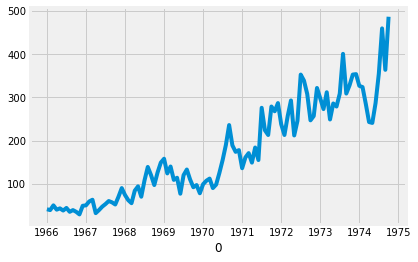

In [36]:
# Line Plot
read.plot()
plt.show()

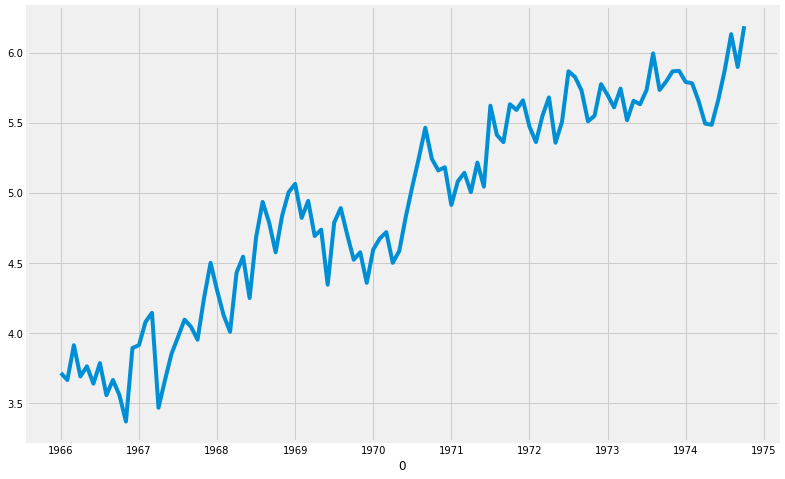

In [41]:
# Change values to log to view more clear plot
s=read.apply(lambda x:np.log(x))
s.plot(figsize=(12,8))

 There is an increasing trend of robberies over time.

 There do not appear to be any obvious outliers.

 There are relatively large ﬂuctuations from year to year, up and down.

 The ﬂuctuations at later years appear larger than ﬂuctuations at earlier years.

 The trend means the dataset is almost certainly non-stationary and the apparent change in ﬂuctuation may also contribute.

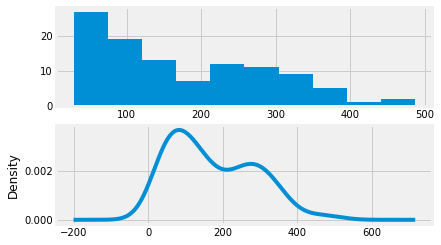

In [37]:
# Density plot
plt.figure(1)
plt.subplot(211)
read.hist()
plt.subplot(212)
read.plot(kind='kde')
plt.show()

C:\Users\minga\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


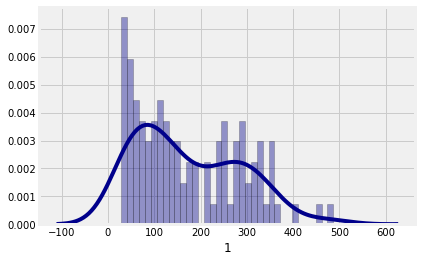

In [38]:
# Density Plot and Histogram
sns.distplot(read, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

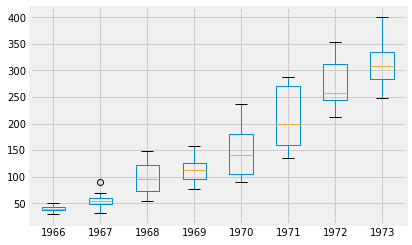

In [46]:
from pandas import Grouper
from pandas import DataFrame
groups=read['1966':'1973'].groupby(Grouper(freq='A'))
years=DataFrame()
for name,group in groups:
    years[name.year]=group.values
years.boxplot()
plt.show()

 Some observations from reviewing the plot include:
 The median values for each year (red line) show a trend that may not be linear.

 The spread, or middle 50% of the data (blue boxes), diﬀer, but perhaps not consistently over time.

 The earlier years, perhaps ﬁrst 2, are quite diﬀerent from the rest of the dataset.

The observations suggest that the year-to-year ﬂuctuations may not be systematic and hard to model. They also suggest that there may be some beneﬁt in clipping the ﬁrst two years of data from modeling if it is indeed quite diﬀerent. This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from year-to-year and changes in summary stats from year-to-year

#### ARIMA Models
we will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem. We will approach modeling by both manual and automatic conﬁguration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model. This section is broken down into 3 steps:
1. Manually Conﬁgure the ARIMA.

2. Automatically Conﬁgure the ARIMA.

3. Review Residual Errors.

###### 1) Manually Configured ARIMA:

Since in practical the time series is certainly non-stationary, we can make it stationary by first differencing the series and using a statistical test to confirm that the result is statioary.

In [49]:
from pandas import Series
# Create a differenced time series:
def difference(datapoint):
    diff=list()  # create empty list
    for i in range (1,len(datapoint)):
        value=datapoint[i]-datapoint[i-1]
        diff.append(value)
    return Series(diff)
    
X=read.values
#difference data
stationary=difference(X)
stationary.index=read.index[1:]

In [52]:
stationary.head()

0
1966-02-01    -2
1966-03-01    11
1966-04-01   -10
1966-05-01     3
1966-06-01    -5
dtype: int64

In [60]:
# Check if stationary
result=adfuller(stationary)
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Values']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.9809463038611255
p-value : 0.0015136348242121929
#Lags Used : 11
Number of Observations Used : 93
Critical Values : {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [61]:
# Test value show -3.98094 is smaller than the critical value at 5% i.e
# -2.893. This mean we can reject null hypothesis.

The next step is to selct the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.We can do this by Autocorrelation function (ACF) and Partial Autocorrelation function (PACF) plots:

C:\Users\minga\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


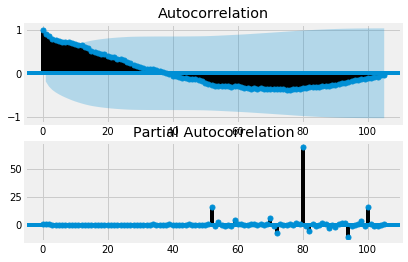

In [64]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(read,ax=plt.gca())
plt.subplot(212)
plot_pacf(read,ax=plt.gca())
plt.show()

C:\Users\minga\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


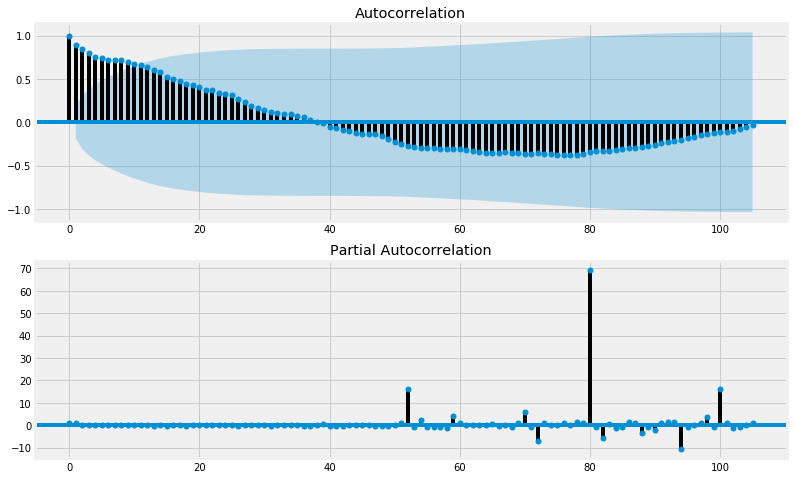

In [63]:
# OR

#plots 
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(read, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(read, ax=ax2)

The ACF shows a signiﬁcant lag for 10-11 months.
 The PACF shows a signiﬁcant lag for perhaps 2 months.

 Both the ACF and PACF show a drop-oﬀ at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p and q values is 1 or 2
This quick analysis suggests an ARIMA(11,1,2) on the raw data may be a good starting point. Experimentation shows that this conﬁguration of ARIMA does not converge and results in errors by the underlying library, as do similarly large AR values. Some experimentation shows that the model does not appear to be stable, with non-zero AR and MA orders deﬁned at the same time. The model can be simpliﬁed to ARIMA(0,1,2).

In [68]:
# let prepare the data 
X=read.values
X=X.astype('float32')
train_size=int(len(X)*0.50)
train,test=X[0:train_size],X[train_size:]
# Walk - forward validation
history=[x for x in train]
predictions=list()
for i in range(len(test)):
    # predict
    model=ARIMA(history,order=(0,1,2))
    model_fit=model.fit(disp=0)
    yhat=model_fit.forecast()[0]
    predictions.append(yhat)
    # y(obs) observation 
    obs=test[i]
    history.append(obs)
    print('Predictied=%.3f, Expected=%.3f' %(yhat,obs))
# Report of performance
rmse=sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' % rmse)

Predictied=102.710, Expected=125.000
Predictied=118.868, Expected=155.000
Predictied=141.099, Expected=190.000
Predictied=176.593, Expected=236.000
Predictied=233.418, Expected=189.000
Predictied=186.905, Expected=174.000
Predictied=184.846, Expected=178.000
Predictied=183.763, Expected=136.000
Predictied=146.180, Expected=161.000
Predictied=171.279, Expected=171.000
Predictied=170.196, Expected=149.000
Predictied=154.425, Expected=184.000
Predictied=185.707, Expected=155.000
Predictied=157.284, Expected=276.000
Predictied=245.280, Expected=224.000
Predictied=222.242, Expected=213.000
Predictied=219.698, Expected=279.000
Predictied=261.506, Expected=268.000
Predictied=264.287, Expected=287.000
Predictied=282.759, Expected=238.000
Predictied=255.843, Expected=213.000
Predictied=235.189, Expected=257.000
Predictied=257.622, Expected=293.000
Predictied=280.345, Expected=212.000
Predictied=235.564, Expected=246.000
Predictied=255.342, Expected=353.000
Predictied=318.613, Expected=339.000
P

This is a good start, but we may be able to get improved results with a better conﬁgured ARIMA model.


#### Grid Search ARIMA Hyperparameters
Many ARIMA conﬁgurations are unstable on this dataset, but there may be other hyperparameters that result in a well-performing model. Here, we will search values of p, d, and q for combinations that do not result in error, and ﬁnd the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values. Speciﬁcally, we will search all combinations of the following parameters:

 p: 0 to 12.
p -> Periods taken for auto regressive model

 d: 0 to 3.
d -> Integrated order, difference

 q: 0 to 12.
q -> Periods in moving average model

This is (p,d,q)=(13×4×13), or 676, runs of the test harness and will take some time to execute. 

In [81]:
# Note : with the best model show (3,1,3) it shows error. let at below do 
# try other way.
import warnings
warnings.filterwarnings('ignore')
ararray =read.values
pdq=[]
aic=[]
d=1
for p in range(6):
    for q in range(4):
        
        try:
            model = ARIMA(ararray,order=(p,d,q)) 
            arima_results = model.fit()
            aic.append(arima_results.aic)
            pdq.append((p,d,q))
            print('ARIMA %s AIC=%.3f' %((p,d,q),arima_results.aic))
        except:
            continue
keys = pdq
values = aic

d = dict(zip(keys, values))
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print ("Best Model is :", (p,d,q))

#p,d,q 
#p -> Periods taken for auto regressive model
#d -> Integrated order, difference
#q -> Periods in moving average model

ARIMA (0, 1, 0) AIC=1070.350
ARIMA (0, 1, 1) AIC=1060.903
ARIMA (0, 1, 2) AIC=1060.208
ARIMA (0, 1, 3) AIC=1059.397
ARIMA (1, 1, 0) AIC=1064.442
ARIMA (1, 1, 1) AIC=1055.695
ARIMA (1, 1, 2) AIC=1057.050
ARIMA (2, 1, 0) AIC=1062.890
ARIMA (2, 1, 1) AIC=1057.090
ARIMA (2, 1, 2) AIC=1059.372
ARIMA (3, 1, 0) AIC=1064.559
ARIMA (3, 1, 1) AIC=1058.991
ARIMA (3, 1, 2) AIC=1061.085
ARIMA (3, 1, 3) AIC=1053.651
ARIMA (4, 1, 0) AIC=1065.160
ARIMA (4, 1, 1) AIC=1060.499
ARIMA (4, 1, 2) AIC=1062.049
ARIMA (4, 1, 3) AIC=1055.389
ARIMA (5, 1, 0) AIC=1066.609
ARIMA (5, 1, 1) AIC=1068.145
ARIMA (5, 1, 2) AIC=1063.952
ARIMA (5, 1, 3) AIC=1056.491
Best Model is : (3, 1, 3)


In [86]:
def evaluate_arima_model(X, arima_order): 
    # prepare training dataset 
    X = X.astype('float32') 
    train_size = int(len(X) * 0.50) 
    train, test = X[0:train_size], X[train_size:] 
    history = [x for x in train] 
    # make predictions 
    predictions = list() 
    for t in range(len(test)): 
        model = ARIMA(history, order=arima_order) 
        model_fit = model.fit(disp=0) 
        yhat = model_fit.forecast()[0] 
        predictions.append(yhat) 
        history.append(test[t]) 
    # calculate out of sample error 
    rmse = sqrt(mean_squared_error(test, predictions)) 
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model 
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32') 
    best_score, best_cfg = float("inf"), None 
    for p in p_values: 
        for d in d_values: 
            for q in q_values: 
                order = (p,d,q) 
                try: 
                    rmse = evaluate_arima_model(dataset, order) 
                    if rmse < best_score: 
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse)) 
                except: 
                    continue 
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# evaluate parameters 
p_values = range(0,13) 
d_values = range(0, 4) 
q_values = range(0, 13) 
warnings.filterwarnings("ignore") 
evaluate_models(read.values, p_values, d_values, q_values)



ARIMA(0, 0, 0) RMSE=175.285
ARIMA(0, 0, 1) RMSE=107.221
ARIMA(0, 1, 0) RMSE=54.343
ARIMA(0, 1, 1) RMSE=52.362
ARIMA(0, 1, 2) RMSE=51.007
ARIMA(0, 1, 3) RMSE=53.009
ARIMA(0, 2, 0) RMSE=87.242
ARIMA(0, 2, 1) RMSE=55.084
ARIMA(1, 0, 0) RMSE=55.085
ARIMA(1, 1, 0) RMSE=52.916
ARIMA(1, 2, 0) RMSE=73.795
ARIMA(2, 0, 0) RMSE=53.853
ARIMA(2, 1, 0) RMSE=52.555
ARIMA(2, 1, 1) RMSE=52.512
ARIMA(2, 2, 0) RMSE=62.568
ARIMA(2, 2, 1) RMSE=53.480
ARIMA(3, 1, 0) RMSE=53.519
ARIMA(3, 1, 1) RMSE=51.576
ARIMA(3, 2, 0) RMSE=63.559
ARIMA(3, 2, 1) RMSE=54.393
ARIMA(4, 1, 0) RMSE=52.686
ARIMA(4, 1, 1) RMSE=53.346
ARIMA(4, 2, 0) RMSE=59.957
ARIMA(4, 2, 1) RMSE=53.773
ARIMA(5, 1, 0) RMSE=53.283
ARIMA(5, 1, 1) RMSE=54.303
ARIMA(5, 2, 0) RMSE=60.894
ARIMA(5, 2, 1) RMSE=54.219
ARIMA(6, 1, 0) RMSE=53.622
ARIMA(6, 2, 0) RMSE=61.965
ARIMA(7, 1, 0) RMSE=52.825
ARIMA(7, 1, 1) RMSE=52.515
ARIMA(7, 2, 0) RMSE=60.754
ARIMA(8, 1, 0) RMSE=53.561
ARIMA(8, 2, 0) RMSE=61.436
Best ARIMA(0, 1, 2) RMSE=51.007


#### Review Residual Errors
A good ﬁnal check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by plotting the residuals with a histogram and density plots. The example below calculates the residual errors for predictions on the test set and creates these density plots.


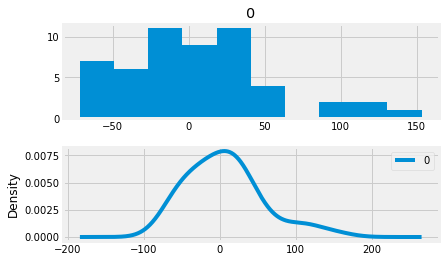

In [87]:
# prepare data
X = read.values
X = X.astype('float32')
train_size = int(len(X) * 0.50) 
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train] 
predictions = list() 
for i in range(len(test)): 
# predict
    model = ARIMA(history, order=(0,1,2)) 
    model_fit = model.fit(disp=0) 
    yhat = model_fit.forecast()[0] 
    predictions.append(yhat) 
    # observation 
    obs = test[i] 
    history.append(obs) 
# errors 
residuals = [test[i]-predictions[i] for i in range(len(test))] 
residuals = DataFrame(residuals) 
plt.figure() 
plt.subplot(211) 
residuals.hist(ax=plt.gca()) 
plt.subplot(212) 
residuals.plot(kind='kde', ax=plt.gca()) 
plt.show()


The graphs suggest a Gaussian-like distribution with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case that perhaps a power-based transform of the raw data before modeling might be useful.
It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data. The example below re-calculates the residual errors and creates ACF and PACF plots to check for any signiﬁcant autocorrelation.


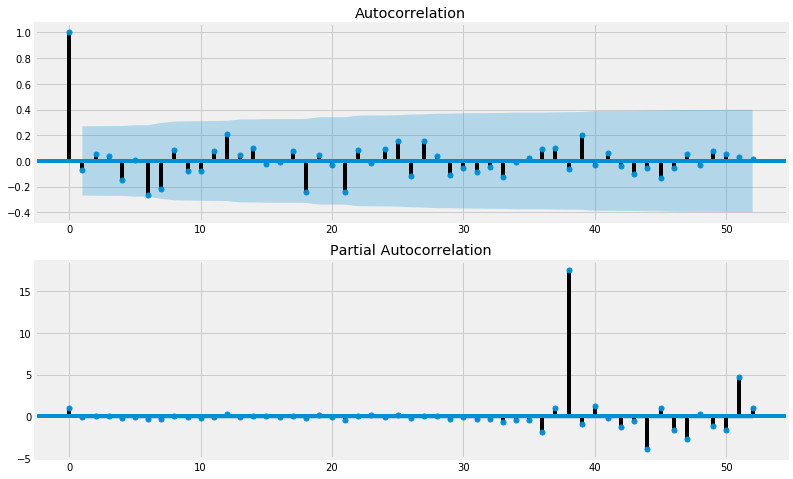

In [89]:
# ACF and PACF plot of the forecast residual errors:
plt.figure(figsize=(12,8))

plt.subplot(211)
plot_acf(residuals,ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals,ax=plt.gca())
plt.show()

The results suggest that what little autocorrelation is present in the time series has been captured by the model.


#### Box-Cox Transformed Dataset
The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data. The example below performs a log transform of the data and generates some plots to review the eﬀect on the time series.


 Lambda: 0.260060


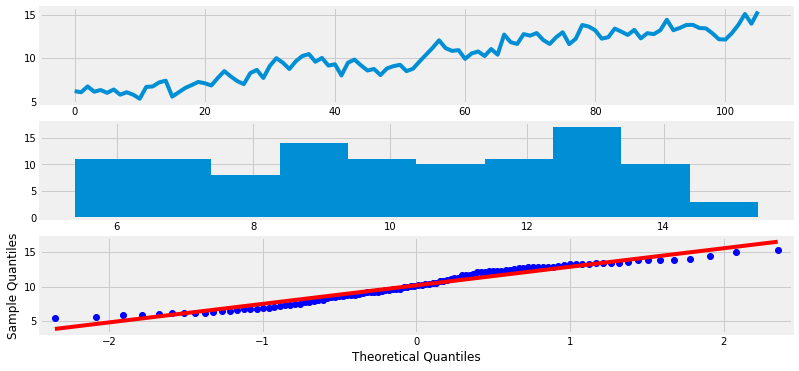

In [92]:
# plot of box-cox transformed dataset
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
X=read.values
transformed,lam=boxcox(X)
print( ' Lambda: %f' % lam)
plt.figure(figsize=(12,6))
plt.subplot(311)
# line plot
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed,line='r',ax=plt.gca())

plt.show()

 a line chart of the transformed time series, a histogram showing the distribution of transformed values, and a Q-Q plot showing how the distribution of values compared to an idealized Gaussian distribution. Some observations from these plots are follows:
 
 The large ﬂuctuations have been removed from the line plot of the time series.

 The histogram shows a ﬂatter or more uniform (well behaved) distribution of values.

 The Q-Q plot is reasonable, but still not a perfect ﬁt for a Gaussian distribution.

Undoubtedly, the Box-Cox transform has done something to the time series and may be useful. Before proceeding to test the ARIMA model with the transformed data, we must have a way to reverse the transform in order to convert predictions made with a model trained on the transformed data back into the original scale. The boxcox() function used in the example ﬁnds an ideal lambda value by optimizing a cost function. The lambda is used in the following

![title](C:\Users\minga\Pictures\timeseries.png)


In [94]:
from IPython.display import Image
from math import log,exp

In [95]:
# Invert Box-cox transform
def boxcox_inv(value,lam):
    if lam==0:
        return exp(value)
    return exp(log(lam*value + 1)/lam)    # this is the formula for inverse boxcox

In [99]:
# prepare data
X = read.values
X = X.astype('float32')
train_size = int(len(X) * 0.50) 
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train] 
predictions = list() 
for i in range(len(test)): 
    # transform
    transformed,lam=boxcox(history)
    if lam<-5:
        transformed,lam=history,1
     # predict
    model = ARIMA(transformed, order=(0,1,2)) 
    model_fit = model.fit(disp=0) 
    yhat = model_fit.forecast()[0] 
    # invert transformed prediction
    yhat=boxcox_inv(yhat,lam)
    predictions.append(yhat) 
    # observation 
    obs = test[i] 
    history.append(obs) 
    print('Predicted= %.3f, Expected= %.3f' % (yhat,obs))
# report performance
rmse=sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' %rmse)

Predicted= 104.062, Expected= 125.000
Predicted= 119.208, Expected= 155.000
Predicted= 138.902, Expected= 190.000
Predicted= 166.143, Expected= 236.000
Predicted= 234.418, Expected= 189.000
Predicted= 183.613, Expected= 174.000
Predicted= 184.409, Expected= 178.000
Predicted= 186.641, Expected= 136.000
Predicted= 154.300, Expected= 161.000
Predicted= 175.672, Expected= 171.000
Predicted= 174.172, Expected= 149.000
Predicted= 159.915, Expected= 184.000
Predicted= 187.303, Expected= 155.000
Predicted= 161.656, Expected= 276.000
Predicted= 244.354, Expected= 224.000
Predicted= 212.416, Expected= 213.000
Predicted= 221.180, Expected= 279.000
Predicted= 262.629, Expected= 268.000
Predicted= 260.126, Expected= 287.000
Predicted= 283.320, Expected= 238.000
Predicted= 255.089, Expected= 213.000
Predicted= 241.692, Expected= 257.000
Predicted= 267.306, Expected= 293.000
Predicted= 286.371, Expected= 212.000
Predicted= 237.881, Expected= 246.000
Predicted= 265.193, Expected= 353.000
Predicted= 3

#### Model Validation
After models have been developed and a ﬁnal model selected, it must be validated and ﬁnalized. Validation is an optional part of the process, but one that provides a last check to ensure we have not fooled or lied to ourselves.

In [101]:
#
X=read.values
X=X.astype('float32')
# transform
transformed,lam=boxcox(X)

     # predict
model = ARIMA(transformed, order=(0,1,2)) 
model_fit = model.fit(disp=0) 
# Save the model
model_fit.save('model.pkl')
#this file is ARIMA result object from the call ARIMA.fit(), it includes all coefficients and all other internal
# data returned when fitting the model.
np.save('model_lambda.npy',[lam])
#This file lambda value stored as a one-row, one-column numpy array

This is probably overkill and all that is really needed for operational use are the AR and MA coeﬃcients from the model, the d parameter for the number of diﬀerences, perhaps the lag observations and model residuals, and the lambda value for the transform.


In [106]:
from statsmodels.tsa.arima_model import ARIMAResults
from math import exp,log 
import numpy as np

In [107]:
# invert box-cox transform 
def boxcox_inverse(value, lam): 
    if lam == 0: 
        return exp(value) 
    return exp(log(lam * value + 1) / lam)


In [108]:
model_fit = ARIMAResults.load('model.pkl') 
lam = np.load('model_lambda.npy') 
yhat = model_fit.forecast()[0] 
yhat = boxcox_inverse(yhat, lam) 
print('Predicted: %.3f' % yhat)

Predicted: 452.043
